# Ejercicio 1: 

### Usa la clase PairWiseAligner de Biopython para alinear secuencias de ADN y obtener la puntuación y el alineamiento óptimo en estos dos escenarios.

In [1]:
from Bio.Align import PairwiseAligner
from Bio.Seq import Seq
from Bio import Entrez, SeqIO
import random
import warnings
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import os

### a) Generar las secuencias aleatoriamente (de forma automática no manual). Las dos secuencias pueden ser de diferente longitud.

#### 1. Generación de secuencias aleatorias

In [2]:
def generate_random_dna_sequence(length):
    return ''.join(random.choice('ACGT') for _ in range(length))

In [3]:
seq1 = Seq(generate_random_dna_sequence(random.randint(10, 20)))
seq2 = Seq(generate_random_dna_sequence(random.randint(15, 25)))

print(seq1)
print(seq2)

AACTGAATAC
TAGCGCGGATGCGGAAAGAAC


#### 2. Alineamiento de secuencias mediante búsqueda en rejilla

In [4]:
param_grid = {
    "mode": ["global", "local"],
    "match_score": [1, 2, 3],
    "mismatch_score": [-1, -2, -3],
    "open_gap_score": [-2, -3, -4],
    "extend_gap_score": [-0.5, -1, -1.5],
}

grid_combinations = list(product(
    param_grid["mode"],
    param_grid["match_score"],
    param_grid["mismatch_score"],
    param_grid["open_gap_score"],
    param_grid["extend_gap_score"],
))

In [5]:
def align_with_parameters(seq1, seq2, **kwargs):
    aligner = PairwiseAligner()
    for key, value in kwargs.items():
        setattr(aligner, key, value)

    alignment = aligner.align(seq1, seq2)
    return alignment.score, alignment

In [6]:
results = []
for params in grid_combinations:
    param_dict = {
        "mode": params[0],
        "match_score": params[1],
        "mismatch_score": params[2],
        "open_gap_score": params[3],
        "extend_gap_score": params[4],
    }
    score, alignment = align_with_parameters(seq1, seq2, **param_dict)

    results.append({
        "params": param_dict,
        "score": score,
        "alignment": alignment,
    })
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="score", ascending=False)

In [16]:
alignment = results_df.iloc[random.randint(0, len(results_df))]["alignment"]
print(alignment[0])

target            0 AA---C---TG----AA-TAC 10
                  0 .|---|---||----||-.|| 21
query             0 TAGCGCGGATGCGGAAAGAAC 21



#### 3. Análisis de resultados

##### 3.1. Visualización de la puntuación en función del valor de los parámetros y el modo

In [10]:
results_df["mode"] = results_df["params"].apply(lambda x: x["mode"])
results_df["match_score"] = results_df["params"].apply(lambda x: x["match_score"])
results_df["mismatch_score"] = results_df["params"].apply(lambda x: x["mismatch_score"])
results_df["open_gap_score"] = results_df["params"].apply(lambda x: x["open_gap_score"])
results_df["extend_gap_score"] = results_df["params"].apply(lambda x: x["extend_gap_score"])

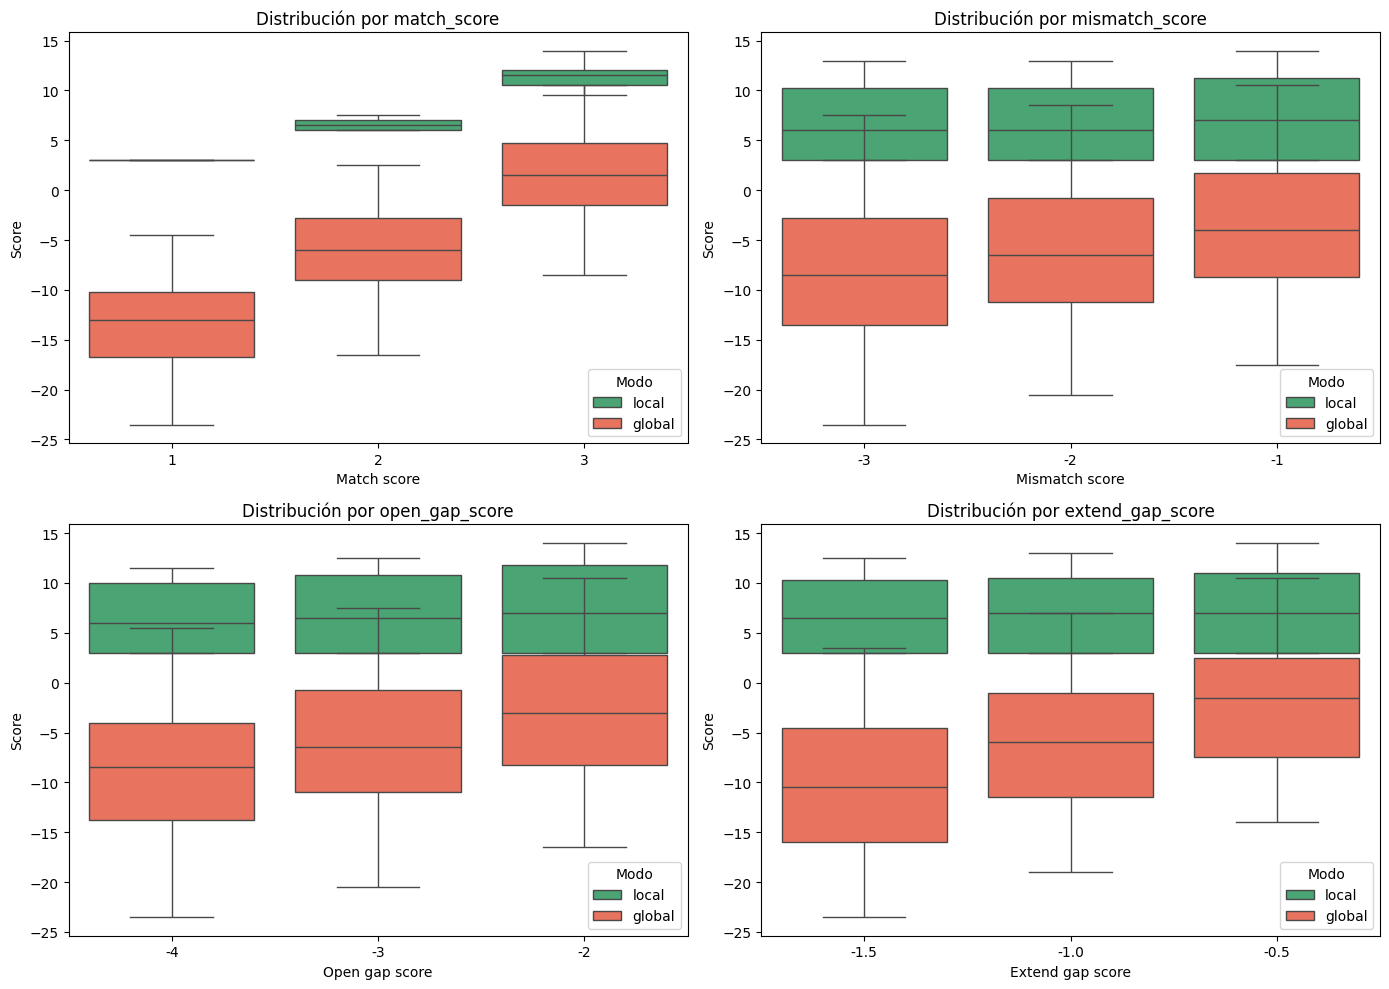

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
param_keys = ["match_score", "mismatch_score", "open_gap_score", "extend_gap_score"]
titles = [
    "Distribución por match_score",
    "Distribución por mismatch_score",
    "Distribución por open_gap_score",
    "Distribución por extend_gap_score"    
]
palette = {
    "global": "tomato",
    "local": "mediumseagreen",
}

for i, key in enumerate(param_keys):
    ax = axes[i // 2, i % 2]
    sns.boxplot(
        data=results_df,
        x=key,
        y="score",
        hue="mode",
        palette=palette,
        dodge=False,
        ax=ax
    )
    ax.set_title(titles[i])
    ax.set_xlabel(key.capitalize().replace("_", " "))
    ax.set_ylabel("Score")
    ax.legend(loc='lower right', title="Modo")

plt.tight_layout()
plt.show()

Por un lado, el modo local ofrece un mejor desempeño en términos de puntajes, especialmente con parámetros más permisivos. Esto se debe a que el alineamiento local se enfoca en las regiones más similares de las secuencias, ignorando áreas menos relevantes. Sin embargo, el modo global es más sensible a penalizaciones, debido a su necesidad de alinear toda la longitud de las secuencias, lo que amplifica el impacto de desajustes y brechas.

Por otro lado, Los parámetros como *match_score* tienen un impacto positivo directo: un mayor valor recompensa mejor las coincidencias entre secuencias mientras que las penalizaciones (*mismatch_score*, *open_gap_score*, *extend_gap_score*) tienen un impacto negativo, reduciendo los puntajes a medida que se vuelven más severas. De todos los parámetros, el *match_score* y el *mismatch_score* parecen tener el mayor efecto en el *score* final.

##### 3.2. Visualización de cómo afectan las puntuaciones obtenidas bajo ciertas condiciones

**3.2.1. Visualización de la distribución de parámetros por rangos de puntuación - Modo local**

El código agrupa las puntuaciones en tres rangos o "bins" utilizando `pd.cut`, generando etiquetas en formato `[min - max]` y asignando cada puntuación a uno de estos grupos (`score_group`). Luego, visualiza cómo los parámetros ajustables (`match_score`, `mismatch_score`, `open_gap_score`, `extend_gap_score`) se distribuyen según los rangos de puntuación, creando subgráficos individuales con curvas de densidad generadas por `sns.kdeplot`. 

In [18]:
warnings.filterwarnings("ignore")
local_results = results_df[results_df["mode"] == "local"]

bins, bin_edges = pd.cut(
    local_results["score"],
    bins=3,
    retbins=True 
)

range_labels = [f"[{bin_edges[i]:.1f} - {bin_edges[i + 1]:.1f}]" for i in range(len(bin_edges) - 1)]
local_results["score_group"] = pd.cut(
    local_results["score"],
    bins=bin_edges,
    labels=range_labels
)

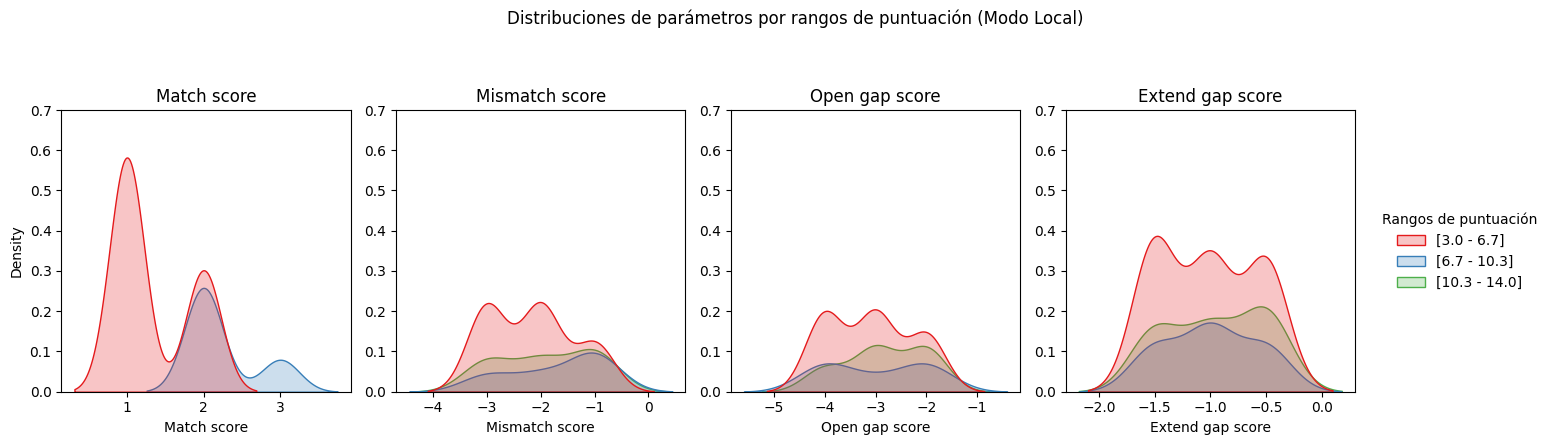

In [19]:
fig, axes = plt.subplots(1, len(local_results[["match_score", "mismatch_score", "open_gap_score", "extend_gap_score"]].columns), figsize=(16, 4))
handles, labels = None, None

for i, var in enumerate(["match_score", "mismatch_score", "open_gap_score", "extend_gap_score"]):
    kde = sns.kdeplot(
        data=local_results,
        x=var,
        hue="score_group",
        fill=True,
        palette="Set1",
        ax=axes[i]
    )
    axes[i].set_title(var.capitalize().replace("_", " "))
    axes[i].set_xlabel(var.capitalize().replace("_", " "))
    axes[i].set_ylim(0, 0.7)

    if i == 0:
        axes[i].set_ylabel("Density")
    else:
        axes[i].set_ylabel("")

    if handles is None and kde.legend_:
        handles, labels = kde.get_legend().get_patches(), kde.get_legend().get_texts()

    if i < len(axes) - 1 and kde.legend_:
        kde.legend_.remove()

if handles and labels:
    axes[-1].legend(
        handles=handles,
        labels=[label.get_text() for label in labels],
        title="Rangos de puntuación",
        bbox_to_anchor=(1.05, 0.5), 
        loc="center left", 
        frameon=False
    )

plt.tight_layout()
plt.suptitle("Distribuciones de parámetros por rangos de puntuación (Modo Local)", y=1.1)
plt.subplots_adjust(top=0.85, right=0.85)
plt.show()

Al observar la visualización, se pueden extraer las siguientes conclusiones sobre las distribuciones de los parámetros y su relación con los rangos de puntuación:

1. **Match Score**: 
   - Las puntuaciones más altas ([12.3 - 17.0]) están asociadas con valores mayores de `match_score` (alrededor de 3).
   - Los rangos de puntuaciones medias ([7.7 - 12.3]) y bajas ([3.0 - 7.7]) tienden a concentrarse en valores más pequeños (cercanos a 1 o 2).
   - Esto sugiere que aumentar el `match_score` favorece puntuaciones más altas.

2. **Mismatch Score**:
   - Las puntuaciones más altas ([12.3 - 17.0]) están asociadas con valores de `mismatch_score` más cercanos a 0.
   - Los rangos de puntuaciones medias y bajas presentan distribuciones más amplias hacia valores negativos (e.g., entre -4 y -1).
   - Esto indica que penalizar menos los desajustes (`mismatch_score` cercano a 0) contribuye a mejores puntuaciones.

3. **Open Gap Score**:
   - Las puntuaciones más altas ([12.3 - 17.0]) tienden a asociarse con valores de `open_gap_score` menos negativos (alrededor de -1.5 a -1).
   - Las puntuaciones más bajas ([3.0 - 7.7]) abarcan valores más negativos (alrededor de -5).
   - Esto sugiere que penalizar menos la apertura de brechas mejora las puntuaciones.

4. **Extend Gap Score**:
   - Las puntuaciones más altas ([12.3 - 17.0]) están asociadas con valores menos negativos de `extend_gap_score` (cercanos a 0).
   - Las puntuaciones más bajas están más relacionadas con valores negativos más extremos (cercanos a -2).
   - Esto indica que penalizar menos la extensión de las brechas es un factor relevante para obtener puntuaciones más altas.

**Conclusión general**:
- Las configuraciones que favorecen puntuaciones más altas en el alineamiento de secuencias incluyen valores altos de `match_score` y valores menos negativos (es decir, penalizaciones más ligeras) para `mismatch_score`, `open_gap_score` y `extend_gap_score`.
- Reducir las penalizaciones parece ser clave para obtener resultados más favorables en términos de puntuación de alineamiento.

**3.2.2. Visualización de la distribución de parámetros por rangos de puntuación - Modo global**

El código realiza algo similar al apartado anterior con la diferencia de que se analiza el modo global.

In [20]:
warnings.filterwarnings("ignore")
global_results = results_df[results_df["mode"] == "global"]

bins, bin_edges = pd.cut(
    global_results["score"],
    bins=6,
    retbins=True 
)

range_labels = [f"[{bin_edges[i]:.1f} - {bin_edges[i + 1]:.1f}]" for i in range(len(bin_edges) - 1)]
global_results["score_group"] = pd.cut(
    global_results["score"],
    bins=bin_edges,
    labels=range_labels
)

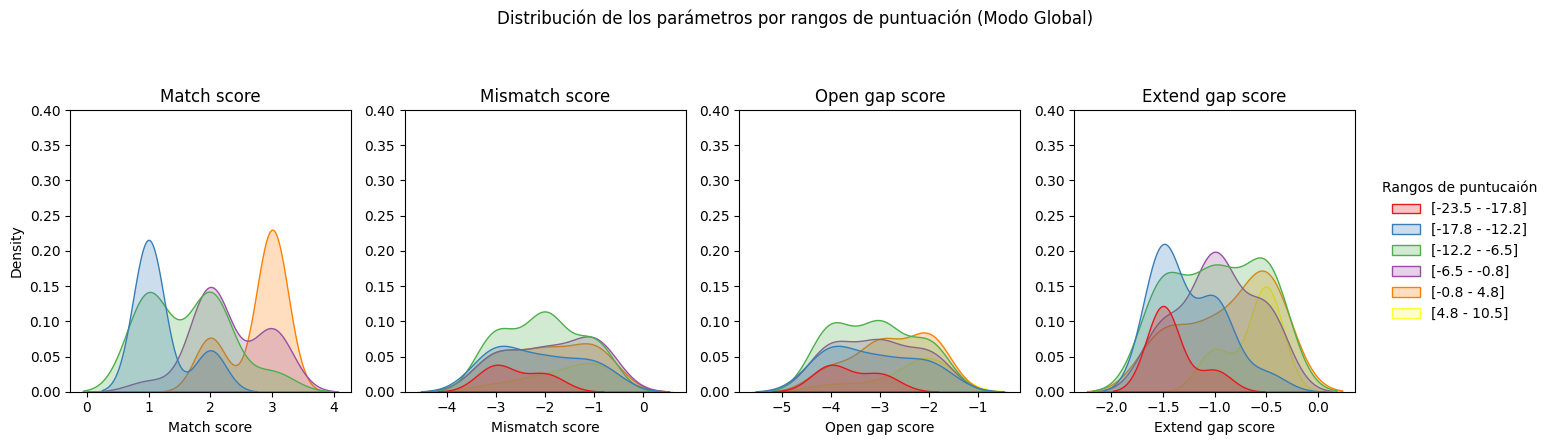

In [23]:
fig, axes = plt.subplots(1, len(global_results[["match_score", "mismatch_score", "open_gap_score", "extend_gap_score"]].columns), figsize=(16, 4))
handles, labels = None, None

for i, var in enumerate(["match_score", "mismatch_score", "open_gap_score", "extend_gap_score"]):
    kde = sns.kdeplot(
        data=global_results,
        x=var,
        hue="score_group",
        fill=True,
        palette="Set1",
        ax=axes[i]
    )
    axes[i].set_title(var.capitalize().replace("_", " "))
    axes[i].set_xlabel(var.capitalize().replace("_", " "))
    axes[i].set_ylim(0, 0.4)

    if i == 0:
        axes[i].set_ylabel("Density")
    else:
        axes[i].set_ylabel("")

    if handles is None and kde.legend_:
        handles, labels = kde.get_legend().get_patches(), kde.get_legend().get_texts()

    if i < len(axes) - 1 and kde.legend_:
        kde.legend_.remove()

if handles and labels:
    axes[-1].legend(
        handles=handles,
        labels=[label.get_text() for label in labels],
        title="Rangos de puntucaión",
        bbox_to_anchor=(1.05, 0.5), 
        loc="center left", 
        frameon=False
    )

plt.tight_layout()
plt.suptitle("Distribución de los parámetros por rangos de puntuación (Modo Global)", y=1.1)
plt.subplots_adjust(top=0.85, right=0.85)
plt.show()

En el contexto del modo global, se pueden extraer las siguientes conclusiones :

**1. Match Score**
- Las puntuaciones más altas ([4.3 - 10.5]) tienden a asociarse con valores de `match_score` mayores, cercanos a 3 y 4.
- Las puntuaciones más bajas ([−26.5 - −20.3]) están asociadas con valores más bajos de `match_score` (cercanos a 1 o menos).
- Un mayor valor de `match_score` tiene una correlación positiva con mejores puntuaciones en el modo global.

**2. Mismatch Score**
- Las puntuaciones más altas ([4.3 - 10.5]) están relacionadas con valores de `mismatch_score` menos negativos (más cercanos a 0).
- Las puntuaciones más bajas ([−26.5 - −20.3]) aparecen asociadas con valores más negativos de `mismatch_score` (alrededor de -3 o menores).
-  Penalizar menos los desajustes (`mismatch_score` más cercano a 0) ayuda a mejorar la puntuación global.

**3. Open Gap Score**
- Las puntuaciones más altas ([4.3 - 10.5]) están asociadas con valores menos negativos de `open_gap_score` (cercanos a -1.5 o -1).
- Las puntuaciones más bajas ([−26.5 - −20.3]) están relacionadas con valores más negativos (alrededor de -5).
- **Conclusión**: Penalizar menos la apertura de brechas contribuye significativamente a obtener puntuaciones más altas en el modo global.

**4. Extend Gap Score**
- Las puntuaciones más altas ([4.3 - 10.5]) se concentran en valores menos negativos de `extend_gap_score` (cercanos a -0.5 o incluso 0).
- Las puntuaciones más bajas ([−26.5 - −20.3]) están asociadas con valores más negativos (alrededor de -2).
- **Conclusión**: Reducir la penalización por la extensión de brechas favorece mejores puntuaciones.

**Conclusión General para el Modo Global**
- Las puntuaciones más altas en el modo global se logran cuando los parámetros favorecen coincidencias altas (`match_score` elevado) y penalizan menos los desajustes (`mismatch_score` cercano a 0) y las brechas (`open_gap_score` y `extend_gap_score` menos negativos).
- En este modo, es clave configurar parámetros que minimicen las penalizaciones para optimizar el alineamiento global.

#### 4. Conclusiones Generales

Los resultados evidencian que el desempeño de los alineamientos está estrechamente ligado a la configuración de parámetros y al tipo de alineamiento seleccionado (local o global). En términos generales, los alineamientos **locales** tienden a ofrecer mejores puntajes debido a su enfoque en regiones altamente similares, mientras que los **globales** son más sensibles a penalizaciones ya que consideran la totalidad de las secuencias.

1. **Impacto de los Parámetros:**
   - **Match Score:** Este parámetro tiene un impacto positivo directo en ambos modos de alineamiento. Valores más altos de *match_score* aumentan significativamente las puntuaciones al recompensar las coincidencias exactas, especialmente en secuencias conservadas. Es el parámetro más determinante para mejorar los puntajes.
   - **Mismatch Score:** Penalizaciones menos estrictas (*mismatch_score* cercano a 0) permiten mayores puntuaciones, ya que reducen el impacto de desajustes. Este efecto es más evidente en alineamientos locales, donde se priorizan regiones similares, mientras que en los globales, los desajustes afectan más debido al alineamiento completo.
   - **Open Gap Score y Extend Gap Score:** Penalizaciones menos severas para abrir y extender brechas son beneficiosas para obtener mejores puntuaciones. En los alineamientos locales, esto permite una mayor flexibilidad en regiones con inserciones o deleciones, mientras que en los globales, el impacto de las brechas es más crítico.

2. **Diferencias entre Modos de Alineamiento:**
   - El **modo local** se destaca por su capacidad para enfocarse en las regiones más relevantes, ignorando partes menos similares de las secuencias. Esto permite manejar configuraciones más permisivas sin un impacto significativo en los puntajes finales, resultando ideal para secuencias con regiones parcialmente conservadas.
   - El **modo global**, en cambio, requiere un ajuste más cuidadoso de los parámetros debido a su sensibilidad a penalizaciones y desajustes. Si bien es más estricto, puede ser útil para obtener una visión general de similitudes a lo largo de toda la longitud de las secuencias.

**Conclusión Final**

Los parámetros deben ajustarse estratégicamente según el propósito del análisis. Para regiones altamente conservadas o análisis focalizados, el modo local con configuraciones permisivas es óptimo. Para comparaciones más amplias y detalladas, el modo global con un balance adecuado entre recompensas (*match_score*) y penalizaciones (*mismatch_score*, *gap scores*) ofrece una visión más completa. Este enfoque permite maximizar la utilidad de los alineamientos para analizar similitudes, diferencias estructurales y relaciones evolutivas entre secuencias.

### b)  Obtener las secuencias a partir de ficheros obtenidos de bases de datos  biológicas. Explicar cómo se obtuvieron.

Este código utiliza las herramientas de NCBI Entrez (una interfaz para buscar y recuperar información biológica) para:

- Buscar secuencias basadas en un término específico (por ejemplo, un nombre de gen o un organismo).
- Obtener los identificadores (IDs) de las secuencias relevantes.
- Descargar las secuencias en formato FASTA.
- Guardar las secuencias en archivos individuales en una carpeta local.

1. Función `get_sequences_ncbi`: esta función realiza una búsqueda en una base de datos de NCBI (como "nucleotide" o "protein") utilizando un término de búsqueda (`search_term`) y obtiene un número limitado de resultados (`max_results`). Posteriormente, llama a otra función para descargar las secuencias encontradas.
2. Función `get_sequences_by_id`: esta función descarga las secuencias de NCBI utilizando los identificadores de secuencia proporcionados. Las secuencias se guardan en archivos FASTA individuales en una carpeta local.

In [13]:
def get_sequences_ncbi(db, search_term, format="fasta", max_results=5, folder="sequences"):

    with Entrez.esearch(db=db, term=search_term, retmax=max_results) as search:
        results = Entrez.read(search)
        ids = results["IdList"]
    routes = get_sequences_by_id(ids, db, folder)
    return routes

def get_sequences_by_id(ids, db="nucleotide", folder="sequences"):
    routes = []
    for id in ids:
        with Entrez.efetch(db=db, id=id, rettype="fasta", retmode="text") as fetch:
            content = fetch.read()
        
        first_line = content.split("\n")[0]
        unique_id = first_line.split()[0][1:]
        filename = unique_id.replace(".", "_") + ".fasta"
        file_route = os.path.join(folder, filename)
        
        with open(file_route, "w") as file:
            file.write(content)
            print(f"File {filename} created")

        routes.append(file_route)
    
    return routes

def read_sequences_from_fasta(routes_files):
    sequences = []
    for file in routes_files:
        for record in SeqIO.parse(file, "fasta"):
            sequences.append(record.seq)
    return sequences


#### 1. Obtención del fichero FASTA de las secuencias

**Caso 1.** Gen BRCA1 (Breast Cancer 1). El gen BRCA1 es un gen humano que codifica una proteína supresora de tumores esencial para el mantenimiento de la estabilidad del ADN y la regulación del ciclo celular. Se encuentra en el cromosoma 17 (17q21). Su función principal está relacionada con la reparación del ADN dañado y la prevención de mutaciones genéticas que podrían conducir al desarrollo del cáncer.

Se propone analizar las diferencias entre las diferentes isoformas (variantes de transcripción) de BRCA1 en humanos.

In [14]:
warnings.filterwarnings("ignore")

search_term="BRCA1[Gene] AND Homo sapiens[Organism] AND isoform[Title]",
fasta_routes = get_sequences_ncbi("nucleotide", search_term, format="fasta", max_results=2)
brca1_isoforms = read_sequences_from_fasta(fasta_routes)

File OP156991_1.fasta created
File OP156990_1.fasta created


**Caso 2.** Gen FOXP2. El gen FOXP2 (Forkhead Box P2) es un gen humano asociado con el desarrollo del lenguaje y el habla. Es uno de los genes más importantes para la comunicación vocal en humanos y otros animales.

Se propone comparar la secuencia del gen FOXP2 en humanos con la secuencia del mismo gen en ratones.

In [15]:
search_term = "FOXP2[Gene] AND Homo sapiens[Organism]"
fasta_human = get_sequences_ncbi("nucleotide", search_term, format="fasta", max_results=1)
foxp2_human = read_sequences_from_fasta(fasta_human)

search_term = "FOXP2[Gene] AND Mus musculus[Organism]"
fasta_mouse = get_sequences_ncbi("nucleotide", search_term, format="fasta", max_results=1)
foxp2_mouse = read_sequences_from_fasta(fasta_mouse)

File NM_148900_4.fasta created
File NM_001286607_1.fasta created


#### 2. Alineamiento de las secuencias de manera global

In [16]:
def final_sequence(alignment,target, query):
    coordinates = alignment.coordinates
    aligned_target=""
    aligned_query=""
    alignment_line=""

    for i in range(coordinates.shape[1] - 1):
        start_t, end_t = coordinates[0, i], coordinates[0, i + 1] 
        start_q, end_q = coordinates[1, i], coordinates[1, i + 1]

        if end_t > start_t and end_q > start_q:
            segment_target = target[start_t:end_t]
            segment_query = query[start_q:end_q]

            aligned_target += segment_target
            aligned_query += segment_query

            for base_t, base_q in zip(segment_target, segment_query):
                if base_t == base_q:
                    alignment_line += base_t
                else:
                    alignment_line += "*"
        elif end_t > start_t:
            aligned_target += target[start_t:end_t]
            aligned_query += "-" * (end_t - start_t)
            alignment_line += "-" * (end_t - start_t)

        elif end_q > start_q:
            aligned_target += "-" * (end_q - start_q)
            aligned_query += query[start_q:end_q]
            alignment_line += "-" * (end_q - start_q)
    return aligned_target, aligned_query, alignment_line

def count_alignment_details(alignment_line):
    gaps = alignment_line.count("-")
    mismatches = alignment_line.count("*")
    matches = len(alignment_line) - gaps - mismatches

    return matches, mismatches, gaps

##### **Caso 1**. Gen BRCA1.

In [17]:
aligner = PairwiseAligner()
aligner.mode = 'global'
aligner.match_score = 0
aligner.mismatch_score = -1
aligner.open_gap_score = -1
aligner.extend_gap_score = -1 

brca_isoform_1 = brca1_isoforms[0]
brca_isoform_2 = brca1_isoforms[1]

In [18]:
alignment = aligner.align(brca_isoform_1, brca_isoform_2)[0]
aligned_target_brca1, aligned_query_brca1, alignment_line_brca1 = final_sequence(alignment, brca_isoform_1, brca_isoform_2)
matches, mismatches, gaps = count_alignment_details(alignment_line_brca1)
print(f"Matches: {matches}, Mismatches: {mismatches}, Gaps: {gaps}, Score: {alignment.score}")

Matches: 3223, Mismatches: 118, Gaps: 257, Score: -375.0


##### **Caso 2.** Gen FOXP2.

In [19]:
aligner = PairwiseAligner()
aligner.mode = 'global'
aligner.match_score = 0
aligner.mismatch_score = -1
aligner.open_gap_score = -1
aligner.extend_gap_score = -1 
alignment = aligner.align(foxp2_human[0], foxp2_mouse[0])[0]

In [20]:
aligned_target, aligned_query, alignment_line_foxp2 = final_sequence(alignment, foxp2_human[0], foxp2_mouse[0])
matches, mismatches, gaps = count_alignment_details(alignment_line_foxp2)
print(f"Matches: {matches}, Mismatches: {mismatches}, Gaps: {gaps}, Score: {alignment.score}")

Matches: 5879, Mismatches: 307, Gaps: 582, Score: -889.0


#### 3. Visualización de los resultados

In [21]:
def plot_alignment_map(alignment_line):
    match_color = [1, 1, 1]
    mismatch_color = [0, 0, 1]
    gap_color = [1, 0, 0]

    color_matrix = np.zeros((2, len(alignment_line), 3))

    for i, char in enumerate(alignment_line):
        if char == "-":
            color_matrix[:, i] = gap_color
        elif char == "*":
            color_matrix[:, i] = mismatch_color
        else:
            color_matrix[:, i] = match_color

    fig, ax = plt.subplots(figsize=(12, 2))
    ax.imshow(color_matrix, aspect='auto', extent=(0, len(alignment_line), 0, 2))


    ax.set_yticks([0, 2])
    ax.set_yticklabels(["Target", "Query"])
    
    x_ticks = list(range(0, len(alignment_line) + 1, 500))
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, fontsize=8)

    ax.set_xlim(0, len(alignment_line))
    ax.set_ylim(0, 2)
    ax.tick_params(left=False, bottom=True, labelbottom=True)
    ax.grid(False)

    plt.title("Alignment Visualization")
    plt.show()

def plot_alignment_segments(alignment_line, segment_length=1000):
    match_color = [1, 1, 1]
    mismatch_color = [0, 0, 1]
    gap_color = [1, 0, 0]

    num_segments = (len(alignment_line) + segment_length - 1) // segment_length

    for seg_idx in range(num_segments):
        start_idx = seg_idx * segment_length
        end_idx = min((seg_idx + 1) * segment_length, len(alignment_line))
        segment = alignment_line[start_idx:end_idx]

        color_matrix = np.zeros((2, len(segment), 3))

        for i, char in enumerate(segment):
            if char == "-":
                color_matrix[:, i] = gap_color
            elif char == "*":
                color_matrix[:, i] = mismatch_color
            else:
                color_matrix[:, i] = match_color

        fig, ax = plt.subplots(figsize=(12, 2))
        ax.imshow(color_matrix, aspect='auto', extent=(start_idx, end_idx, 0, 2))

        ax.set_yticks([0, 2])
        ax.set_yticklabels(["Target", "Query"])

        x_ticks = list(range(start_idx, end_idx, 500))
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks, fontsize=8)

        ax.set_xlim(start_idx, end_idx)
        ax.set_ylim(0, 2)
        ax.tick_params(left=False, bottom=True, labelbottom=True)
        ax.grid(False)

        plt.title(f"Alignment Visualization (Region {start_idx}-{end_idx})")
        plt.show()

def plot_alignment_segments_by_locations(alignment_line, segment_locations):
    match_color = [1, 1, 1]
    mismatch_color = [0, 0, 1]
    gap_color = [1, 0, 0]

    for start_idx, end_idx in segment_locations:
        segment = alignment_line[start_idx:end_idx]
        color_matrix = np.zeros((2, len(segment), 3))

        for i, char in enumerate(segment):
            if char == "-":
                color_matrix[:, i] = gap_color
            elif char == "*":
                color_matrix[:, i] = mismatch_color
            else:
                color_matrix[:, i] = match_color

        fig, ax = plt.subplots(figsize=(12, 2))
        ax.imshow(color_matrix, aspect='auto', extent=(start_idx, end_idx, 0, 2))

        ax.set_yticks([0, 2])
        ax.set_yticklabels(["Target", "Query"])

        x_ticks = list(range(start_idx, end_idx, 500))
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_ticks, fontsize=8)

        ax.set_xlim(start_idx, end_idx)
        ax.set_ylim(0, 2)
        ax.tick_params(left=False, bottom=True, labelbottom=True)
        ax.grid(False)

        plt.title(f"Alignment Visualization (Region {start_idx}-{end_idx})")
        plt.show()

##### **Caso 1.** Gen BRCA1.

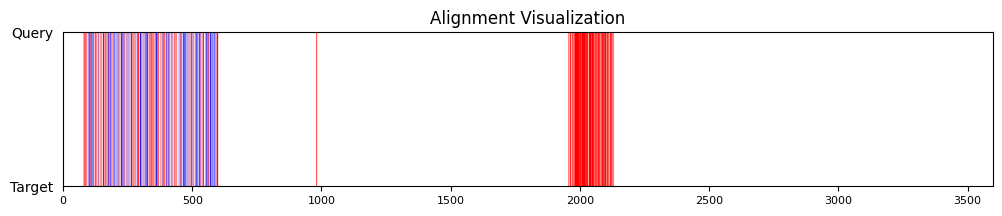

In [22]:
plot_alignment_map(alignment_line_brca1)

La representación visual y el análisis que compartiste se relacionan con la alineación de dos isoformas del gen BRCA1 en humanos, enfocándose en coincidencias, desajustes y brechas dentro de sus secuencias. Las conclusiones que pueden extraerse de estas visualizaciones incluyen:

1. **Resumen de la alineación**: La visualización destaca las regiones donde las dos isoformas se alinean perfectamente (coincidencias), las regiones donde hay diferencias (desajustes) y las brechas (inserciones o deleciones) entre las secuencias.

2. **Observaciones**:
   - En la imagen, la parte izquierda de la alineación muestra una región densamente alineada, con variaciones indicadas por desajustes o brechas.
   - Hay una brecha clara en la parte central de la alineación, lo que sugiere una región grande no alineada, probablemente debido a diferencias estructurales entre las isoformas.
   - En la parte derecha también se observa otra región densamente alineada.

3. **Diferencias entre isoformas**:
   - Los desajustes y las brechas sugieren diferencias funcionales o regulatorias entre las isoformas.
   - La presencia de brechas grandes (como la del medio) podría indicar eventos como dominios específicos de isoformas, omisión de exones o splicing alternativo.

**Conclusión general:**
Aunque las isoformas tienen un grado significativo de similitud (como se ve en las regiones alineadas), las diferencias observadas en los desajustes y brechas indican variaciones significativas que podrían explorarse más para comprender su relevancia biológica. Esto es especialmente importante para el papel de BRCA1 como supresor de tumores y en el mantenimiento de la estabilidad del ADN.

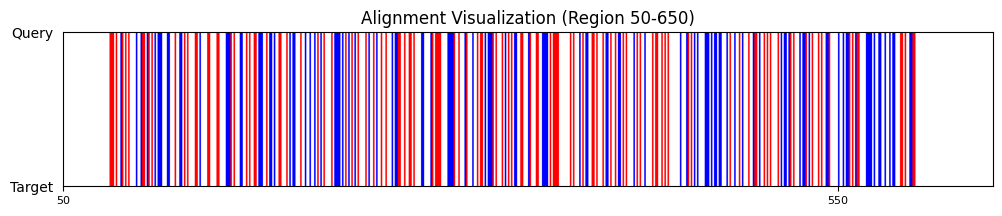

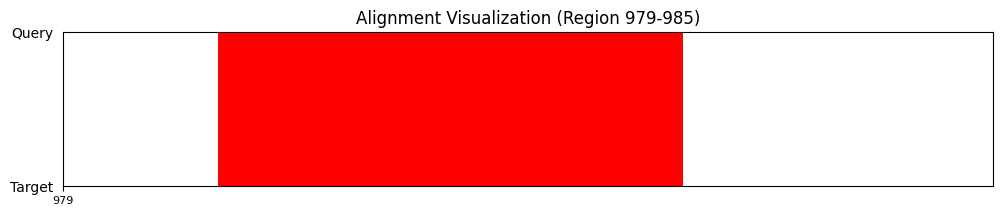

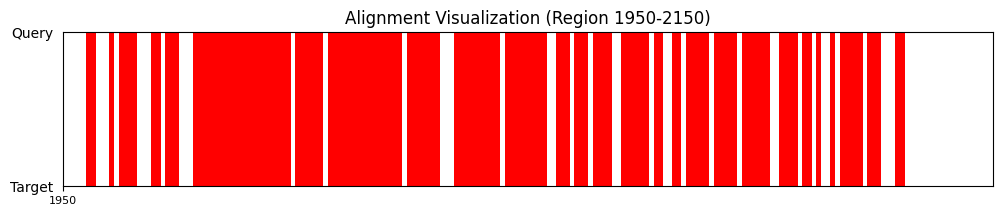

In [23]:
segment_locations = [(50, 650), (979, 985), (1950, 2150)]
plot_alignment_segments_by_locations(alignment_line_brca1, segment_locations)

Al analizar los segmentos de alineación críticos, se pueden identificar conclusiones específicas para cada región:

- **Región 50-650** Este segmento muestra una mezcla de coincidencias (blanco), desajustes(azul) y algunos huecos (gaps)(rojo). Este comportamiento podría indicar regiones con una alta variabilidad, como áreas propensas a secuencias reguladoras específicas de cada isoforma.

- **Región 979-985** Se observa una brecha (gap) completamente roja, lo que sugiere una región donde una de las isoformas tiene una inserción o la otra una deleción. Este tipo de diferencias podría ser consecuencia de una omisión o inclusión de un exon en una de las isoformas.

- **Región 1950-2150** Hay una alta densidad de huecos y desajustes en este segmento, con menos coincidencias en comparación con otros Esto podría reflejar una región con modificaciones estructurales importantes entre las isoformas, como una región altamente variable o con diferencias significativas en la longitud.

**Conclusión General**
- Los resultados por segmentos confirman que hay variabilidad significativa entre las isoformas del gen **BRCA1**, probablemente debido a eventos de splicing alternativo o mutaciones específicas. Las **regiones estables** (con más coincidencias) sugieren conservación funcional, mientras que las **regiones variables** pueden reflejar adaptaciones o especializaciones funcionales.

##### **Caso 2.** Gen FOXP2.

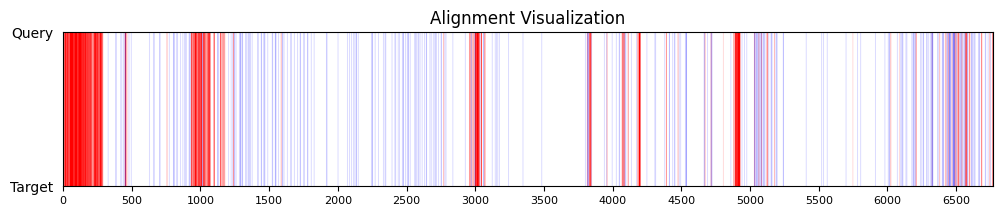

In [24]:
plot_alignment_map(alignment_line_foxp2)

Con base en el análisis del gen **FOXP2** en humanos y ratones, junto con la visualización de la alineación, se pueden extraer las siguientes conclusiones:

**1. Alineación global**
- **Coincidencias (matches)**: Indican regiones altamente conservadas entre humanos y ratones, lo cual es esperable para un gen crítico como FOXP2, relacionado con el desarrollo del lenguaje y funciones cognitivas.
- **Desajustes (mismatches)**: Reflejan variaciones nucleotídicas específicas entre las especies, que podrían estar asociadas con diferencias funcionales en las proteínas codificadas.
- **Gaps (brechas)**: Representan inserciones o deleciones entre las secuencias, posiblemente relacionadas con eventos evolutivos, como duplicaciones o pérdidas de segmentos de ADN.

**2. Observaciones de la visualización**
- La imagen muestra patrones de conservación y variabilidad a lo largo de la alineación:
  - **Regiones altamente conservadas** (blancas): Sugieren secuencias críticas para la funcionalidad del gen FOXP2, como dominios de unión al ADN o regiones esenciales para su actividad reguladora.
  - **Regiones con brechas (rojas)**: Indican diferencias estructurales importantes, probablemente relacionadas con funciones adaptativas específicas de cada especie.
  - **Desajustes dispersos (azules)**: Podrían reflejar mutaciones puntuales que alteran la secuencia pero no necesariamente la estructura global de la proteína.

**Conclusión**
El análisis sugiere que el gen FOXP2 presenta una conservación significativa entre humanos y ratones, lo que resalta su importancia funcional. Sin embargo, las variaciones observadas (gaps y desajustes) apuntan a diferencias evolutivas que pueden estar relacionadas con las especializaciones funcionales en cada especie. 

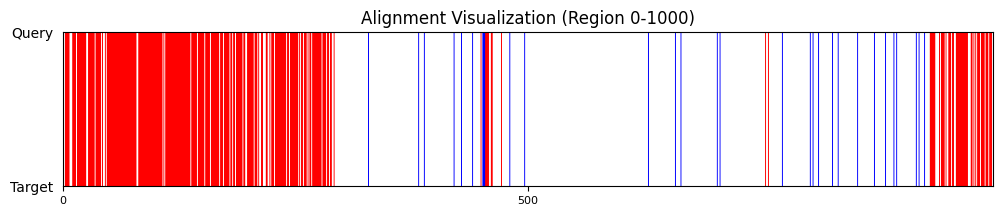

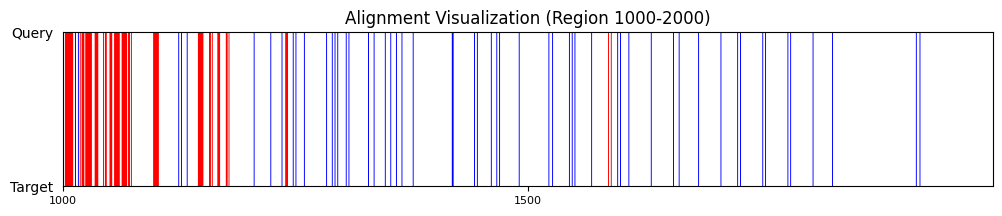

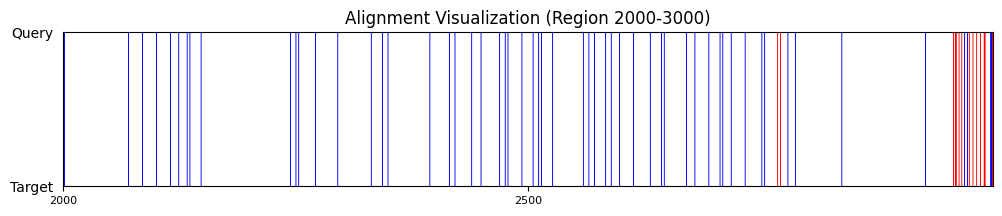

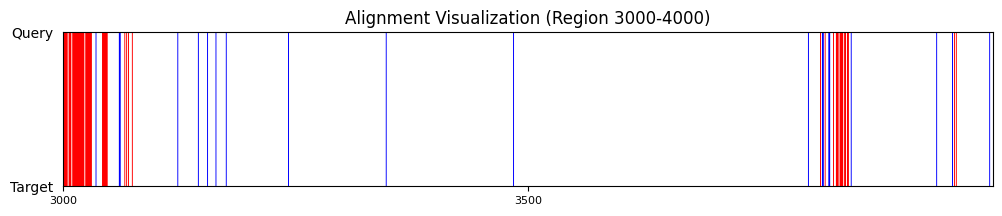

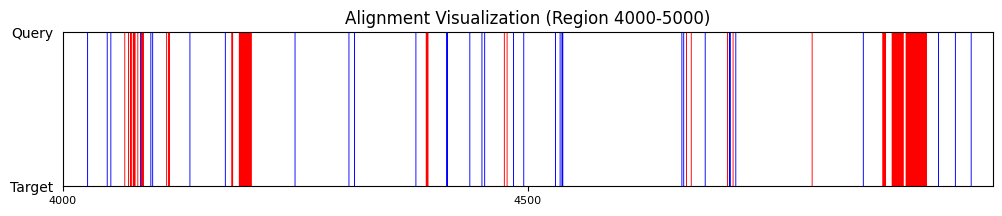

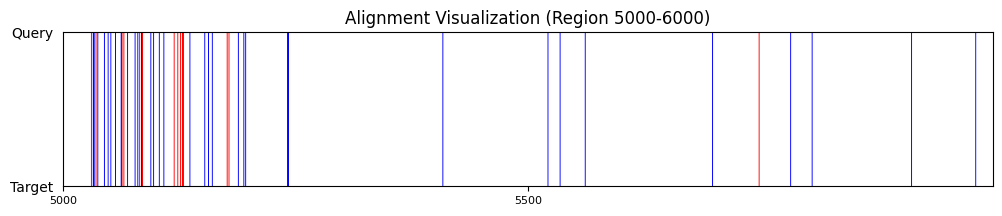

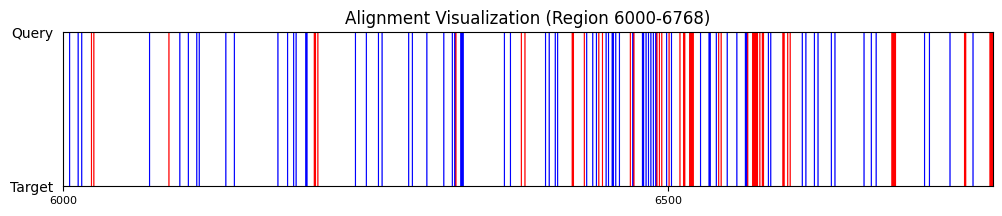

In [25]:
plot_alignment_segments(alignment_line_foxp2)

- **Segmento 0-1000:** Este segmento presenta una alta densidad de gaps (rojo) en las posiciones iniciales, seguida por áreas más dispersas con coincidencias (blanco) y desajustes (azul).Los gaps iniciales pueden reflejar diferencias estructurales significativas entre las secuencias humanas y de ratón, como inserciones o deleciones y las áreas dispersas con coincidencias indican que, aunque hay similitud, esta región contiene variaciones específicas que podrían estar asociadas con funciones adaptativas.

- **Segmento 1000-2000:** En esta región, la densidad de gaps disminuye, pero los desajustes (azul) son más frecuentes. Esto sugiere una región menos estructuralmente conservada pero funcionalmente similar, posiblemente con mutaciones puntuales que no alteran significativamente la funcionalidad general.

- **Segmento 2000-3000:** Se observa una menor densidad de gaps, y predominan los desajustes dispersos, con áreas de coincidencia ocasional.Este patrón sugiere que esta región está parcialmente conservada, pero hay diferencias específicas que podrían indicar adaptaciones o cambios en regiones no críticas de la proteína.

- **Segmento 3000-4000:** Se evidencia una mayor cantidad de gaps en los extremos del segmento, con una región central de desajustes dispersos. Las brechas podrían indicar la presencia de inserciones o deleciones evolutivas. La región central más variable puede estar relacionada con adaptaciones específicas para funciones distintas en humanos y ratones.

- **Segmento 4000-5000:** La proporción de gaps y desajustes sigue siendo alta, aunque hay áreas cortas con coincidencias completas. Esto sugiere una mezcla de regiones críticas (conservadas) y no críticas (variables). Las áreas conservadas podrían estar relacionadas con dominios funcionales clave.

- **Segmento 5000-6000:** Aquí se observa una distribución más uniforme de gaps y desajustes, con pocas coincidencias. La región parece tener variabilidad significativa, posiblemente relacionada con funciones menos esenciales o modificaciones adaptativas específicas en cada especie.

- **Segmento 6000-6768:** En este último segmento hay un patrón similar al anterior, con gaps dispersos y áreas cortas de coincidencias, especialmente hacia el final.

**Conclusión general del análisis por segmentos**
1. **Regiones altamente variables (con gaps y desajustes frecuentes)**:
   - Corresponden a áreas de divergencia evolutiva significativa, que podrían no ser esenciales o estar sujetas a presiones selectivas diferentes en humanos y ratones.

2. **Regiones conservadas (coincidencias blancas)**:
   - Sugieren la preservación de dominios funcionales críticos, esenciales para el papel del gen FOXP2 en ambas especies.

3. **Impacto funcional**:
   - Este análisis indica que, aunque el gen FOXP2 es funcionalmente conservado en humanos y ratones, las diferencias observadas pueden estar relacionadas con adaptaciones evolutivas, como el desarrollo del lenguaje en humanos o funciones cognitivas específicas.


### Prueba a cambiar los parámetros del alineador como el esquema de puntuación, las penalizaciones de alineamiento y la modalidad de alineamiento (global o local). Compara los resultados obtenidos con diferentes configuraciones y explica las diferencias.